# Load and pre-process data

## Investigate dataset folder

the dog breed dataset folder includes three main folders: train, valid and test. As suggested by its name, images in folder are the direct input where the learning step bases on to estimate gradient and update the parameters. Images in the validation folder is for evaluating the accurary of the model after each epoch. The last folder, test, contains images which we will use at the last step to calculate the model's accuracy. These images are considered as the real world data, which our model has never seen, and is reliable for evaluation purpose.

Because each dog breed is stored in a separate folder, we use the folder name as the label for the underlying images. 

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(f'dogImages/train')
valid_files, valid_targets = load_dataset(f'dogImages/valid')
test_files, test_targets = load_dataset(f'dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob(f'dogImages/train/*/'))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


## Prepare input tensors

In both training and testing step, the input to neural network are $4D$ tensor as following:

$$
(\text{n_samples},  \text{rows}, \text{columns}, \text{channels})
$$

where `n_samples` is the total number of images, `rows` and `columns` are size and `channels` are the number of channels of each image. In our case, `channels` is 3, equivalent to  `RGB` channels.

The function `path_to_tensor` takes input as a path to a single image, import, resize to the size of $(224,224)$ and then convert it to a 4D tensor, whose shape is
$$
(\text{1},  \text{rows}, \text{columns}, \text{channels})
$$

The function `paths_to_tensor` receives input as a list of path to images, forward each path to the function `path_to_sensor` to get a single 4D tensor, and finally, stack all of them together to build the final tensor.  

We repeat calling `paths_to_tensor` to build tensors for training, valid and test sets.

After loading all tensors, we divide images by 255 to convert pixel values to the range of $[0, 1]$

In [2]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [3]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:07<00:00, 111.47it/s]


# Give it a try:  train a model from scratch

Before reaching out to transfer learning, I tried to train a model from scratch to  see how far I can go with.

The architecture I built below is a simplified version of VGG-11, which uses multiple continuous small convolutional layers instead of layers with large receptive field (11 or 7) like in the Alexnet architecture. Two 3x3 kernels are equavalent to a 5x5 kernel, and three 3x3 kernels are equavalent to a single 7x7 kernel, but use less parameters. Specifically, two 3x3 kernels will take  $(2*3*3*C*C) =  18*C^2 paramers $ while a single 5x5 kernel will take $5*5*C^2 parameters$. This trick gives us a gain of 28% of memory usage.

In this architecture, I also incorporate 1x1 convolution layers after 3x3 ones. This 1x1 convolution layer serves as a cross-channel mapping among feature maps from previous layer, decoupling depth correlation from spatial correlation within a feature map and might give the model an easier time to learn. Moreover, it also adds non-linearity to the model, helping it learn more complex representation.

Finally, I use the global average pooling layer as a bridge between the last convolution layer and the fully connected layer. GAP calculates average value of each feature map separatedly, transforming a convolution layer of size (14x14x512) to a connected layer of size (512). This kind of pooling is more native to the nature of convolution because it gives a smooth transition from feature maps to full connected layer. It also helps reduce overfitting because the average operator doesn't use any parameters. 

In [4]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import keras as keras
import matplotlib.pyplot as plt

In [6]:
keras.backend.clear_session()

model = Sequential()

model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(512, kernel_size=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))

#model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
#model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(133, activation='softmax'))


model.summary()
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)       590080    
__________

In [10]:
checkpoint_log = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', save_best_only=True, verbose=1)
history = model.fit(train_tensors, train_targets, epochs=10, validation_data=(valid_tensors, valid_targets), callbacks=[checkpoint_log], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 36s 5ms/step - loss: 4.9435 - acc: 0.0063 - val_loss: 4.8750 - val_acc: 0.0096

Epoch 00001: val_loss improved from inf to 4.87504, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 31s 5ms/step - loss: 4.8770 - acc: 0.0108 - val_loss: 4.8701 - val_acc: 0.0108

Epoch 00002: val_loss improved from 4.87504 to 4.87011, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
6680/6680 [==============================] - 31s 5ms/step - loss: 4.8806 - acc: 0.0096 - val_loss: 4.8689 - val_acc: 0.0108

Epoch 00003: val_loss improved from 4.87011 to 4.86890, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
6680/6680 [==============================] - 31s 5ms/step - loss: 4.8822 - acc: 0.0112 - val_loss: 4.8693 - val_acc: 0.0108

Epoch 00004: val_loss did not improve from 4.86890
Epoch 5/10
668

## Find an epoch number

In the below graph, the change of training and validation losses over time are plotted over each other. It could be seen that, after 5 epochs, the training loss keeps decreasing but the validation loss starts increasing. It is a sign that model starts overfitting to the training set and losing its ability to generalize to the validation set. Therefore, it would be better to stop training after 5 epochs. 

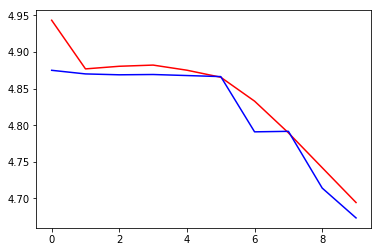

In [15]:
plt.plot(history.history['loss'], c='r')
plt.plot(history.history['val_loss'], c='b')

## Evaluate accuracy

In [7]:
model.load_weights(filepath='saved_models/weights.best.from_scratch.hdf5')

In [28]:
preds = model.predict(test_tensors)
accuracy = [np.argmax(preds[i]) == np.argmax(test_targets[i]) for i in range(preds.shape[0])]
accuracy = 100 * (np.sum(accuracy) / len(test_targets))

In [32]:
print(f'accuracy = {accuracy}%')

accuracy = 2.751196172248804%


Even our accuracy of 2.75% is 5 times higher than a random prediction, it is still far away from a reliable  model. I guess there are several reasons behind it.

 1. Our model is trained from scratch on a small dataset of just around 6000 images. For the trained model to better generalize to test images, it must be trained on large dataset of several million of images. For example, as stated in the XCeption paper, it took around one month training on a dataset of 30 million of images using a cluster of 20 GPUs.
 
 2. The dataset just consists of dog images, while it is believed that a more diversified dataset will help the model learn more meaningul features.
 
 3. Our architecture is not deep enough.
 
Unfortunately, due to the limited computing resource, we are not able to train a deep architecture like VCG16 or Resnet. It would be more beneficial to apply transfer learning in this problem. 

# Transfer learning

Transfer learning means we reuse a pre-trained models on our dataset. The pre-trained model are ones that are trained on big dataset and have a larger generalization ability. Choosing a appropriate approach to apply transfer learning often depends on the size and similarity between our dataset and the pre-trained model dataset.

1. If our dataset is similar to the pre-trained dataset, we just need to use the pre-trained model as a feature extractor. It means that we pass our dog images through the model, take the feature maps from the last convolution layer and train our fully connected network on these feature maps. In contrast, if our dataset is different, we might need to fine-tune the pre-trained model with a low learning rate. 

2. Regarding the second aspect, if your dataset is small, we should consider just using the pre-trained model as a feature extractor because updating a pre-trained weight on a small dataset could cause it overfitting to the dataset. Otherwise, if we have a big dataset, we can freely fine-tune a pre-trained model.   

In our case, the dataset is quite small and the model which I plan to use Resnet50 was trained on ImageNet, which is a large datase and has lots of dog images. Therefore, it could be reasonable to just use pre-trained Resnet50 as a feature extractor and train a our own fully connected network. In general, the process is as in below.

1. use pre-trained Resnet50 to extract feature maps from our dog breed images.

2. create a fully connected network.

3. train the network using feature maps and corresponding targets. 

## Feature extraction